In [1]:
import numpy as np
np.set_printoptions(linewidth=100)
import sympy as sm
import sympy.abc as sbl
from scipy.sparse import diags
import scipy.sparse.linalg as la
import scipy.sparse as sp
sm.init_printing()
import time
import matplotlib.pyplot as plt
import matplotlib

# Hyperparameters

In [2]:
N = 5
h = 1 /N

# Domain

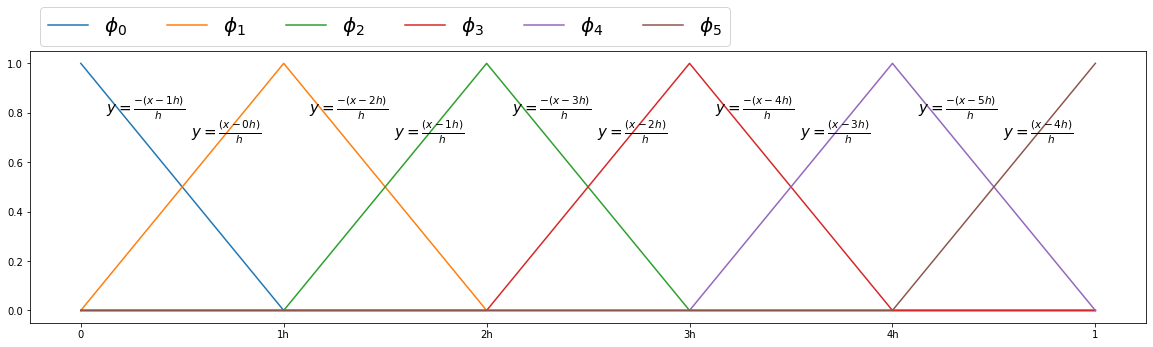

In [3]:
l = []

for i in range(N + 1):
    arr = np.array([0]* (N + 1))
    arr[i] = 1
    l.extend([np.linspace(0, 1, N+1), arr])
plt.figure(figsize=(20, 5))
#plt.margins(x=0, y=0)
plt.plot(*l)

leg = plt.legend([r"$\phi_{}$".format(i) for i in range(N+1)],loc = 2, prop={'size': 20}, ncol=8,  bbox_to_anchor=(0, 1.2 ),   )

for i in range(N + 1):
    if i!=N :
        ann = plt.annotate(r'$ y = \frac {{-(x-{}h)}}{{h}}$'.format(i+1), xy =(i*h+h/4, 1-h), xytext=(i*h+h/8, 1-h))
        ann.set_fontsize(15)
    if i!=0:
        ann = plt.annotate(r'$ y = \frac {{(x-{}h)}}{{h}}$'.format(i-1), xy = (i*h+h/4, 1-h), xytext=(i*h-h/2.2, 1-h-h/2))
        ann.set_fontsize(15)
        
x_ticks = plt.xticks([0. , 0.2, 0.4, 0.6, 0.8, 1.] , ["0"]+[f"{i}h" for i in range(1, N)]+[str(1)])

## Equations 

\begin{equation}
\underline {System \ of \ equations :}
\\\ u_t + u  u_x + v_x + \beta u_{xx} = 0 
\\ v_t + (uv)_x - \beta v_{xx} = 0 
\end{equation}

\begin{equation}
\underline { Discrete \ Galerkin \ Solution :}
\\ u^h = 
\sum_{i= 0}^{n} a_i  \phi_i 
\end{equation}

\begin{equation}
\underline {System \ of \ equations :}
\\\ \int_0^1 { (w u_t + wu  u_x + wv_x + \beta w u_{xx})} \ dx= 0 
\\ \int_0^1 { (wv_t + w (uv)_x - \beta w v_{xx})} \ dx= 0 
\end{equation}



# Trial Case

\begin{equation}
\underline {System \ of \ equations :  Heat \ Equation }
\\\ \int {( w u_t  + \beta w u_{xx})} \ dx = 0 
\end{equation}


\begin{equation}
\underline {System \ of \ equations :}
\\\ \int_0^1  w u_t  \ dx  + \beta \ (w(1) u_x(1) - w(0) u_x(0)) - \beta \int_0^1 {w_x u_x} \ dx= 0 
\\  A \alpha^{'} \hspace{30mm} +\beta ( B \alpha \hspace{5mm} - C \alpha) \hspace{10mm} - \beta D  \alpha  = 0 \thinspace\thinspace\thinspace  \ just\ the \ matrices
\\ w = {\phi_j}
\end{equation}

## A   integrate

In [4]:
sm.Matrix([[sm.Symbol(f"\int_0^1 \phi_{i}")* sm.Symbol(f"phi_{j}") \
            if abs(i-j) in [0, 1]  else 0 for j in range(N+1) ] for i in range(N+1)]) # A

⎡\int_0_0__1 \phi⋅φ₀  \int_0_0__1 \phi⋅φ₁           0                    0    
⎢                                                                             
⎢\int_0_1__1 \phi⋅φ₀  \int_0_1__1 \phi⋅φ₁  \int_0_1__1 \phi⋅φ₂           0    
⎢                                                                             
⎢         0           \int_0_2__1 \phi⋅φ₁  \int_0_2__1 \phi⋅φ₂  \int_0_2__1 \p
⎢                                                                             
⎢         0                    0           \int_0_3__1 \phi⋅φ₂  \int_0_3__1 \p
⎢                                                                             
⎢         0                    0                    0           \int_0_4__1 \p
⎢                                                                             
⎣         0                    0                    0                    0    

                0                    0         ⎤
                                               ⎥
                0               

### Integration of consecutive three( vertically)

In [5]:
x, k, h = sm.symbols("x k h")

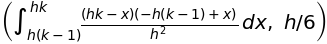

In [6]:
IA1 = sm.Integral((-(x-k*h)/h)*(x-(k-1)*h)/h, (x, (k-1)*h, k*h))
(IA1, sm.simplify(IA1.doit()))                #above

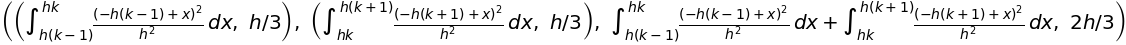

In [7]:
IA2 = (sm.Integral(((x-(k-1)*h)/h)**2, (x, (k-1)*h, k*h)) , sm.Integral(((x-(k+1)*h)/h)**2, (x, (k)*h, (k+1)*h)))
(IA2[0], sm.simplify(IA2[0].doit())), (IA2[1], sm.simplify(IA2[1].doit())), sum(IA2), sm.simplify(sum(IA2).doit())  #middle

# 0, 0 and N, N has single value h/3 not 2h/3

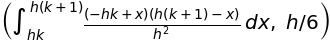

In [8]:
IA3 = sm.Integral((-(x-(k+1)*h)/h)* ((x-k*h)/h), (x, k*h, (k+1)*h)) 
(IA3, sm.simplify(IA3.doit()))   #bottom

In [9]:
def fA(i, j):
    if (i==j) and j in [0, N]:
        return h/3
    elif i==j:
        return 2*h/3
    elif abs(i-j) == 1:
        return h/6
    else:
        return 0
sm.Matrix(N+1, N+1, lambda i, j: fA(i, j))

⎡h   h                   ⎤
⎢─   ─    0    0    0   0⎥
⎢3   6                   ⎥
⎢                        ⎥
⎢h  2⋅h   h              ⎥
⎢─  ───   ─    0    0   0⎥
⎢6   3    6              ⎥
⎢                        ⎥
⎢    h   2⋅h   h         ⎥
⎢0   ─   ───   ─    0   0⎥
⎢    6    3    6         ⎥
⎢                        ⎥
⎢         h   2⋅h   h    ⎥
⎢0   0    ─   ───   ─   0⎥
⎢         6    3    6    ⎥
⎢                        ⎥
⎢              h   2⋅h  h⎥
⎢0   0    0    ─   ───  ─⎥
⎢              6    3   6⎥
⎢                        ⎥
⎢                   h   h⎥
⎢0   0    0    0    ─   ─⎥
⎣                   6   3⎦

## B   (!!do not integrate)    calculated at point 1

In [10]:
sm.Matrix([[sm.Symbol(f"\phi_{i}^{{'}}(1)")* sm.Symbol(f"\phi_{j} (1)")\
            if abs(i-j) in[0, 1] and j==N  else 0 for j in range(N+1)] for i in range(N+1)])

⎡0  0  0  0  0              0            ⎤
⎢                                        ⎥
⎢0  0  0  0  0              0            ⎥
⎢                                        ⎥
⎢0  0  0  0  0              0            ⎥
⎢                                        ⎥
⎢0  0  0  0  0              0            ⎥
⎢                                        ⎥
⎢0  0  0  0  0  \phi_4__{'}(1)⋅\phi_5 (1)⎥
⎢                                        ⎥
⎣0  0  0  0  0  \phi_5 (1)⋅\phi_5__{'}(1)⎦

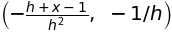

In [11]:
IB1 =  (((x-(1- h))/h) *(-1/h))   #(4, 5)
IB1, IB1.subs({x:1})

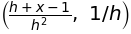

In [12]:
IB2 =  (((x-(1- h))/h) *(1/h))   #(5, 5)
IB2, IB2.subs({x:1})

In [13]:
def fB(i, j):
    if (i==j==N):  
        return 1/h
    elif i + 1 ==N and j== N :
        return -1/h
    else:
        return 0
sm.Matrix(N+1, N+1, lambda i, j: fB(i, j))

⎡0  0  0  0  0   0 ⎤
⎢                  ⎥
⎢0  0  0  0  0   0 ⎥
⎢                  ⎥
⎢0  0  0  0  0   0 ⎥
⎢                  ⎥
⎢0  0  0  0  0   0 ⎥
⎢                  ⎥
⎢               -1 ⎥
⎢0  0  0  0  0  ───⎥
⎢                h ⎥
⎢                  ⎥
⎢                1 ⎥
⎢0  0  0  0  0   ─ ⎥
⎣                h ⎦

## C   (!!do not integrate)    calculate at point 0

In [14]:
sm.Matrix([[sm.Symbol(f"\phi_{i}^{{'}}(0)")* sm.Symbol(f"\phi_{j} (0)")\
            if abs(i-j) in[0, 1] and j==0  else 0 for j in range(N+1)] for i in range(N+1)])

⎡\phi_0 (0)⋅\phi_0__{'}(0)  0  0  0  0  0⎤
⎢                                        ⎥
⎢\phi_0 (0)⋅\phi_1__{'}(0)  0  0  0  0  0⎥
⎢                                        ⎥
⎢            0              0  0  0  0  0⎥
⎢                                        ⎥
⎢            0              0  0  0  0  0⎥
⎢                                        ⎥
⎢            0              0  0  0  0  0⎥
⎢                                        ⎥
⎣            0              0  0  0  0  0⎦

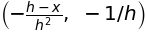

In [15]:
IC1 =  (-(x-h)/h) *(-1/h)  #(0, 0)
IC1, IC1.subs({x:0})

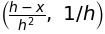

In [16]:
IC2 =  (-(x-h)/h) *(1/h)   #(1, 0)
IC2, IC2.subs({x:0})

In [17]:
def fC(i, j):
    if (i==j==0):  
        return -1/h
    elif i - 1 ==0 and j== 0 :
        return 1/h
    else:
        return 0
sm.Matrix(N+1, N+1, lambda i, j: fC(i, j))

⎡-1                ⎤
⎢───  0  0  0  0  0⎥
⎢ h                ⎥
⎢                  ⎥
⎢ 1                ⎥
⎢ ─   0  0  0  0  0⎥
⎢ h                ⎥
⎢                  ⎥
⎢ 0   0  0  0  0  0⎥
⎢                  ⎥
⎢ 0   0  0  0  0  0⎥
⎢                  ⎥
⎢ 0   0  0  0  0  0⎥
⎢                  ⎥
⎣ 0   0  0  0  0  0⎦

## D  integrate

In [18]:
sm.Matrix([[sm.Symbol(f"\int_0^1 \phi_{i}'")* sm.Symbol(f"phi_{j}^'")\
            if abs(i-j) in [0, 1]  else 0 for j in range(N+1)] for i in range(N+1)]) # D

⎡\int_0_0'__1 \phi⋅φ_0__'  \int_0_0'__1 \phi⋅φ_1__'             0             
⎢                                                                             
⎢\int_0_1'__1 \phi⋅φ_0__'  \int_0_1'__1 \phi⋅φ_1__'  \int_0_1'__1 \phi⋅φ_2__' 
⎢                                                                             
⎢           0              \int_0_2'__1 \phi⋅φ_1__'  \int_0_2'__1 \phi⋅φ_2__' 
⎢                                                                             
⎢           0                         0              \int_0_3'__1 \phi⋅φ_2__' 
⎢                                                                             
⎢           0                         0                         0             
⎢                                                                             
⎣           0                         0                         0             

            0                         0                         0            ⎤
                                                   

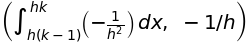

In [19]:
IA1 = sm.Integral((-1/h)*(1/h), (x, (k-1)*h, k*h))
(IA1, sm.simplify(IA1.doit()))                #above

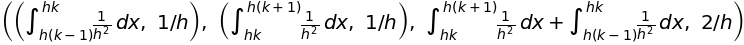

In [20]:
IA2 = (sm.Integral((1/h)**2, (x, (k-1)*h, k*h)) , sm.Integral((1/h)**2, (x, (k)*h, (k+1)*h)))
(IA2[0], sm.simplify(IA2[0].doit())), (IA2[1], sm.simplify(IA2[1].doit())), sum(IA2), sm.simplify(sum(IA2).doit())  #middle

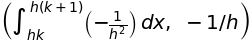

In [21]:
IA3 = sm.Integral((-1/h)* (1/h), (x, k*h, (k+1)*h)) 
(IA3, sm.simplify(IA3.doit()))   #bottom

<h1><u> Integral Calculator</u></h1>

<html><h1 style="color:#cc0c36;">Code Begins</h1></html>

In [22]:
#No of basis functions
N = 100 

# x step size
h = 1/N

# constant
beta = .5


A = sp.csc_matrix(diags([     [h/3, *[2*h/3]*(N-1), h/3], \
                              [h/6]*(N),         \
                              [h/6]*(N)],               [0, 1, -1] ))

B = sp.csc_matrix( ([-1/h, 1/h],([N-1, N], [N, N]),), shape=(N+1, N+1) )

C = sp.csc_matrix( ([-1/h, 1/h],([0, 1], [0, 0])), shape=(N+1, N+1) )

D = sp.csc_matrix(diags([     [1/h, *[2/h]*(N-1), 1/h], \
                              [-1/h]*(N),         \
                              [-1/h]*(N)],               [0, 1, -1] ))

alpha = np.array([np.sin((x+1)*np.pi/2) - np.cos((x+1)*np.pi/2)   for x in np.linspace(0, 1, N+1) ]).reshape(-1, 1)


In [23]:
A.todense()

matrix([[0.00333333, 0.00166667, 0.        , ..., 0.        , 0.        , 0.        ],
        [0.00166667, 0.00666667, 0.00166667, ..., 0.        , 0.        , 0.        ],
        [0.        , 0.00166667, 0.00666667, ..., 0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00666667, 0.00166667, 0.        ],
        [0.        , 0.        , 0.        , ..., 0.00166667, 0.00666667, 0.00166667],
        [0.        , 0.        , 0.        , ..., 0.        , 0.00166667, 0.00333333]])

In [24]:
B.todense()

matrix([[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0., -100.],
        [   0.,    0.,    0., ...,    0.,    0.,  100.]])

In [25]:
C.todense()

matrix([[-100.,    0.,    0., ...,    0.,    0.,    0.],
        [ 100.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]])

In [26]:
D.todense()

matrix([[ 100., -100.,    0., ...,    0.,    0.,    0.],
        [-100.,  200., -100., ...,    0.,    0.,    0.],
        [   0., -100.,  200., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,  200., -100.,    0.],
        [   0.,    0.,    0., ..., -100.,  200., -100.],
        [   0.,    0.,    0., ...,    0., -100.,  100.]])

In [27]:
alpha

array([[1.        ],
       [1.01558395],
       [1.03091732],
       [1.04599633],
       [1.06081725],
       [1.07537643],
       [1.08967028],
       [1.10369527],
       [1.11744793],
       [1.13092489],
       [1.14412281],
       [1.15703843],
       [1.16966857],
       [1.18201011],
       [1.19406   ],
       [1.20581528],
       [1.21727305],
       [1.22843047],
       [1.23928479],
       [1.24983334],
       [1.26007351],
       [1.27000278],
       [1.27961869],
       [1.28891887],
       [1.29790104],
       [1.30656296],
       [1.31490252],
       [1.32291764],
       [1.33060634],
       [1.33796675],
       [1.34499702],
       [1.35169544],
       [1.35806035],
       [1.36409018],
       [1.36978344],
       [1.37513873],
       [1.38015472],
       [1.38483018],
       [1.38916395],
       [1.39315497],
       [1.39680225],
       [1.40010488],
       [1.40306207],
       [1.40567306],
       [1.40793723],
       [1.40985401],
       [1.41142293],
       [1.412

# Eqn form: a1 1 + a2 x2 + a3 x3 ....   a(n-1) x(n-1) + an 1 = 0
#                 a2 x2 + a3 x3 ....   a(n-1) x(n-1) =  -( an 1  +a1 1 )

\begin{equation}
\\  A \alpha^{'}  +\beta ( B \alpha  - C \alpha)  - \beta D  \alpha  = 0 \thinspace\thinspace\thinspace  
\\ \text {Cropping  \( 0^{th} \)  and \( N^{th} \) rows since we know that at boundary values are 1}
\\ \text {Now cropping \( 0^{th} \)  and \( N^{th} \) columns  and shifting to other side as done in header to get matrix in that form}
\\ \text {Equation system now becomes like \(2^{nd} \) equation in header and matrices get reduced to (n - 1) \(\times \) (n-1) dimensions}
\\ \text {New equation system :} 
\ \hspace{250mm}
\\ \text {\(\tilde{A} \) \(\tilde{\alpha^{'}} \) + \( \beta \) ( \(\tilde{B} \) \(\tilde{\alpha} \) - \(\tilde{C} \) \(\tilde{\alpha} \)) - \( \beta \)  \(\tilde{D} \) \(\tilde{\alpha} \) = 0}  
\end{equation}

In [28]:
A_ = A[1:-1, 1: -1]
B_ = B[1:-1, 1: -1]
C_ = C[1:-1, 1: -1]
D_ = D[1:-1, 1: -1]
alpha_ = alpha[1:-1]
shifted = A[1:-1, 0]+ A[1:-1, -1]

In [29]:
A_.todense()

matrix([[0.00666667, 0.00166667, 0.        , ..., 0.        , 0.        , 0.        ],
        [0.00166667, 0.00666667, 0.00166667, ..., 0.        , 0.        , 0.        ],
        [0.        , 0.00166667, 0.00666667, ..., 0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00666667, 0.00166667, 0.        ],
        [0.        , 0.        , 0.        , ..., 0.00166667, 0.00666667, 0.00166667],
        [0.        , 0.        , 0.        , ..., 0.        , 0.00166667, 0.00666667]])

In [30]:
B_.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
C_.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
D_.todense()

matrix([[ 200., -100.,    0., ...,    0.,    0.,    0.],
        [-100.,  200., -100., ...,    0.,    0.,    0.],
        [   0., -100.,  200., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,  200., -100.,    0.],
        [   0.,    0.,    0., ..., -100.,  200., -100.],
        [   0.,    0.,    0., ...,    0., -100.,  200.]])

In [33]:
shifted.todense()

matrix([[0.00166667],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0

\begin{equation}
\\ \text {\(\tilde{A} \) \(\tilde{\alpha^{'}} \) + \( \beta \) ( \(\tilde{B} \) \(\tilde{\alpha} \) - \(\tilde{C} \) \(\tilde{\alpha} \)) - \( \beta \)  \(\tilde{D} \) \(\tilde{\alpha} \) + \(shifted \) = 0}  
\\  \implies \tilde{A} \tilde{\alpha^{'}} +\beta( \tilde{B}  - \tilde{C }- \tilde{D} )) \tilde{\alpha} + shifted = 0
\\  \hspace{8mm} \implies  \tilde{\alpha^{'}} =  - \tilde{A^{-1}}  [ \beta ( ( \tilde{ B} \ - \tilde{ C} -\tilde{ D} )) \alpha + \ shifted) ] 
\end{equation}

In [34]:
x, k, t = sm.symbols("x k t")
expr = sm.exp(t)*sm.sin(sm.pi*x)*(1+sm.pi**2)
pos = sm.simplify(sm.integrate(expr*(x-(k-1)*h)/h, (x, h*(k-1),h*k)))
neg = sm.simplify(sm.integrate(expr*-(x-(k+1)*h)/h, (x, h*(k),h*(k+1))))
pos = sm.lambdify([k,t], pos, "numpy")
neg = sm.lambdify([k,t], neg, "numpy")


In [35]:


def f(y, t_):
    f_t = np.array([0]+[pos(k, t_) for k in range(1, N+1)]) +\
    np.array([neg(k, t_) for k in range(0, N)]+[0]) 
    f_t = f_t[1:-1].reshape(N-1, 1)
    return -la.inv(A_).dot( beta * ( B_ - C_ - D_).dot(y) + shifted - f_t)

In [36]:
step_size = h**2 #time step

runs = 10 #no of iterations

t_=0

y = alpha_

for i in range(runs):
    k1 = f( y, t_)
    k2 = f( y+.5*k1*h,t_)
    k3 = f(y+.5*k2*h,t_)
    k4 = f( y+k3*h,t_)
    y_new = y + (1/6)*(k1 + 2*k2 + 2*k3 + k4)*step_size
    y_new = y
    print("Iteration ",  i+1,"  t  : ", t_)
    time.sleep(.1)
    t_ = t_ + h**2


Iteration  1   t  :  0
Iteration  2   t  :  0.0001
Iteration  3   t  :  0.0002
Iteration  4   t  :  0.00030000000000000003
Iteration  5   t  :  0.0004
Iteration  6   t  :  0.0005
Iteration  7   t  :  0.0006000000000000001
Iteration  8   t  :  0.0007000000000000001
Iteration  9   t  :  0.0008000000000000001
Iteration  10   t  :  0.0009000000000000002


\begin{equation}
\ u^{h}
\end{equation}

In [37]:
u_h =y
u_h

array([[1.01558395],
       [1.03091732],
       [1.04599633],
       [1.06081725],
       [1.07537643],
       [1.08967028],
       [1.10369527],
       [1.11744793],
       [1.13092489],
       [1.14412281],
       [1.15703843],
       [1.16966857],
       [1.18201011],
       [1.19406   ],
       [1.20581528],
       [1.21727305],
       [1.22843047],
       [1.23928479],
       [1.24983334],
       [1.26007351],
       [1.27000278],
       [1.27961869],
       [1.28891887],
       [1.29790104],
       [1.30656296],
       [1.31490252],
       [1.32291764],
       [1.33060634],
       [1.33796675],
       [1.34499702],
       [1.35169544],
       [1.35806035],
       [1.36409018],
       [1.36978344],
       [1.37513873],
       [1.38015472],
       [1.38483018],
       [1.38916395],
       [1.39315497],
       [1.39680225],
       [1.40010488],
       [1.40306207],
       [1.40567306],
       [1.40793723],
       [1.40985401],
       [1.41142293],
       [1.41264361],
       [1.413

\begin{equation}
\ u
\end{equation}

In [42]:
u = np.exp(t_)*np.sin(np.pi*np.linspace(0, 1, N+1))

array([0.00000000e+00, 3.14421855e-02, 6.28533415e-02, 9.42024687e-02, 1.25458629e-01,
       1.56590978e-01, 1.87568790e-01, 2.18361494e-01, 2.48938701e-01, 2.79270237e-01,
       3.09326166e-01, 3.39076828e-01, 3.68492861e-01, 3.97545237e-01, 4.26205284e-01,
       4.54444717e-01, 4.82235669e-01, 5.09550712e-01, 5.36362890e-01, 5.62645742e-01,
       5.88373332e-01, 6.13520267e-01, 6.38061733e-01, 6.61973508e-01, 6.85231995e-01,
       7.07814242e-01, 7.29697961e-01, 7.50861556e-01, 7.71284141e-01, 7.90945563e-01,
       8.09826416e-01, 8.27908069e-01, 8.45172676e-01, 8.61603200e-01, 8.77183425e-01,
       8.91897976e-01, 9.05732332e-01, 9.18672839e-01, 9.30706727e-01, 9.41822120e-01,
       9.52008048e-01, 9.61254460e-01, 9.69552229e-01, 9.76893167e-01, 9.83270029e-01,
       9.88676523e-01, 9.93107312e-01, 9.96558025e-01, 9.99025254e-01, 1.00050657e+00,
       1.00100050e+00, 1.00050657e+00, 9.99025254e-01, 9.96558025e-01, 9.93107312e-01,
       9.88676523e-01, 9.83270029e-01, 9.76

ValueError: x and y must have same first dimension, but have shapes (99,) and (101,)

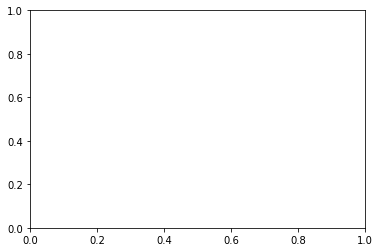

In [40]:
plt.plot(np.linspace(0, 1, N+1)[1:-1], y, np.linspace(0, 1, N+1)[1:-1], u)

# Basis Functions

In [ ]:
N = 4

In [ ]:
h = 1/sm.Rational(N)

In [ ]:
x = sm.abc.x

In [ ]:
def phi(i):
    
    if i == 0 :
        return sm.Piecewise( ( ( -x + (i+1)*h) / h, (x >=i*h) & (x <= (i+1)*h)) , \
                           (0, True) 

                      )
    elif i == N:
        return sm.Piecewise(  ((x - (i-1)*h) / h, (x >=(i-1)*h) & (x <= i*h))   , \
                   (0, True) 
                                       )             
    else:
        return sm.Piecewise(
                           ((x - (i-1)*h) / h, (x >=h*(i-1)) & (x <= i*h))    , \
                           ( ( -x + (i+1)*h) / h, (x >=i*h) & (x <= (i+1)*h)) , \
                           (0, True)  
                       )

